# Determination of a prospective tariff for a telecom company

Cellular operator "Megaline" offers customers two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

Purpose: to conduct a preliminary analysis of tariffs on a small sample of customers and identify the best tariff

Data: data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018.

Tariff Description

Tariff "Smart"
1. Monthly fee: 550 rubles
2. Included 500 minutes of calls, 50 messages and 15 GB of Internet traffic
3. The cost of services in excess of the tariff package:
o minute of conversation: 3 rubles
o message: 3 rubles
o 1 GB of Internet traffic: 200 rubles

Tariff "Ultra"
1. Monthly fee: 1950 rubles
2. Included 3000 minutes of calls, 1000 messages and 30 GB of internet traffic
3. The cost of services in excess of the tariff package:
o minute of conversation: 1 ruble
o message: 1 ruble
o 1 GB of Internet traffic: 150 rubles

Note:
Megaline always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded up separately: even if it lasted only 1 second, it will be counted as 1 minute.
For web traffic, individual sessions are not counted. Instead, the monthly total is rounded up. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes.


## Data Acquaintance

In [36]:
import pandas as pd
import math
import numpy as np

In [37]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

In [38]:
data_unit = (data_users, data_tariffs, data_calls, data_messages, data_internet)
for data in data_unit:
    data.info()
    display()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null 

In data_users, you need to change the type to DateTime for churn_date and reg_date.
Data_internet has a strange unnamed column, needs to be fixed. session_date translate to DateTime.
In data_calls, you need to translate call_date into DateTime.
In data_messages, you need to convert to DateTime message_date.

In [39]:
data_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [40]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [41]:
data_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [42]:
data_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [43]:
data_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


id in all tables is recognized as a string. This is the id of the user_id and the number of the entry that belongs to it. It turns out user_id is redundant, you can remove it.
The unnamed field, according to the first data, duplicates the id of the DF itself. It needs to be checked and removed.
No suspicious gaps were found in the tables. 

## Data preprocessing
Let's convert columns with dates to the Datetime format

In [44]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

In [45]:
len(data_internet['Unnamed: 0'].unique())
data_internet['Unnamed: 0'].tail()

149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, dtype: int64

The number of elements in the Unnamed column is the same as the number of indexes - delete the column.

In [46]:
del data_internet['Unnamed: 0']

In [47]:
for data in data_unit:
    print(data.duplicated().sum())
    print()

0

0

0

0

0



No obvious duplicates were found in the table. Let's round up the duration of calls to the minute and the used GB, as stated in the terms of use of the tariff.

In [48]:
data_calls['duration'] = data_calls['duration'].apply(math.ceil)
data_internet['mb_used'] = data_internet['mb_used'].apply(math.ceil)

### Results of data preprocessing

No duplicates were found. The extra column Unnamed has been removed. Time and date values have been converted to the correct format.
They were rounded up to the whole number of minutes and megabytes in order to correctly calculate how much is required and how much the user will actually need to pay for communication services.

## Calculation of additional parameters

It is necessary to calculate for each user:

• number of calls made and spent minutes of conversation by month;

• number of sent messages by month;

• volume of used Internet traffic by months;

• monthly revenue from each user.

In [49]:
data_calls['month'] = data_calls['call_date'].dt.month
data_calls_month = data_calls.pivot_table(index=['user_id', 'month'], values=["duration"], aggfunc=['sum', 'count'])
data_calls_month.columns = ['month_call_duration', 'month_call_count']
data_calls_month

month_call_duration  month_call_count
user_id month                                       
1000    5                      159                22
        6                      172                43
        7                      340                47
        8                      408                52
        9                      466                58
...                            ...               ...
1498    10                     247                41
1499    9                       70                 9
        10                     449                68
        11                     612                74
        12                     492                69

[3174 rows x 2 columns]

In [50]:
data_messages['month'] = data_messages['message_date'].dt.month
data_messages_month = data_messages.pivot_table(index=['user_id', 'month'], values=["message_date"], aggfunc=['count'])
data_messages_month.columns = ['month_message_count']
data_messages_month

month_message_count
user_id month                     
1000    5                       22
        6                       60
        7                       75
        8                       81
        9                       57
...                            ...
1498    10                      42
1499    9                       11
        10                      48
        11                      59
        12                      66

[2717 rows x 1 columns]

In [51]:
data_internet['month'] = data_internet['session_date'].dt.month
data_internet_month = data_internet.pivot_table(index=['user_id', 'month'], values=["mb_used"], aggfunc=['sum'])
data_internet_month.columns = ['month_mb_used']
data_internet_month

month_mb_used
user_id month               
1000    5               2256
        6              23257
        7              14016
        8              14070
        9              14581
...                      ...
1498    10             20604
1499    9               1848
        10             17809
        11             17984
        12             13077

[3203 rows x 1 columns]

In [52]:
data_calls_month.info()
data_internet_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   month_call_duration  3174 non-null   int64
 1   month_call_count     3174 non-null   int64
dtypes: int64(2)
memory usage: 62.9 KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   month_mb_used  3203 non-null   int64
dtypes: int64(1)
memory usage: 38.5 KB


In [53]:
data_users_info = data_calls_month.combine_first(data_messages_month)
data_users_info = data_users_info.combine_first(data_internet_month)

data_users_info = data_users_info.reset_index(level = 'month')
data_users_info_with_tariff = data_users_info.merge(data_users[['user_id', 'tariff', 'city']], on='user_id', how='outer')

data_users_info_with_tariff

,user_id,month,month_call_count,month_call_duration,month_mb_used,month_message_count,tariff,city
0,1000,5.0,22.0,159.0,2256.0,22.0,ultra,Краснодар
1,1000,6.0,43.0,172.0,23257.0,60.0,ultra,Краснодар
2,1000,7.0,47.0,340.0,14016.0,75.0,ultra,Краснодар
3,1000,8.0,52.0,408.0,14070.0,81.0,ultra,Краснодар
4,1000,9.0,58.0,466.0,14581.0,57.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1499,10.0,68.0,449.0,17809.0,48.0,smart,Пермь
3212,1499,11.0,74.0,612.0,17984.0,59.0,smart,Пермь
3213,1499,12.0,69.0,492.0,13077.0,66.0,smart,Пермь
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский


In [54]:
data_users_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1000 to 1499
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                3214 non-null   int64  
 1   month_call_count     3174 non-null   float64
 2   month_call_duration  3174 non-null   float64
 3   month_mb_used        3203 non-null   float64
 4   month_message_count  2717 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


In [55]:
data_users_info_with_tariff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              3216 non-null   int64  
 1   month                3214 non-null   float64
 2   month_call_count     3174 non-null   float64
 3   month_call_duration  3174 non-null   float64
 4   month_mb_used        3203 non-null   float64
 5   month_message_count  2717 non-null   float64
 6   tariff               3216 non-null   object 
 7   city                 3216 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 226.1+ KB


In [56]:
def calculate_under_limit(row, current_tariff_data, row_filed_name, tariff_field_name):
    result = 0
    if (row[row_filed_name] > current_tariff_data[tariff_field_name]):
        result = row[row_filed_name] - current_tariff_data[tariff_field_name]
        
    return result

def calculate_proceeds(row):
    tariff_index_dict = {'smart' : 0, 'ultra': 1}
    tariff_index = tariff_index_dict[row['tariff']]
    current_tariff_data = data_tariffs.loc[tariff_index]
    
    minutes_under_limit = calculate_under_limit(row, current_tariff_data, 'month_call_duration', 'minutes_included')
    mb_under_limit = calculate_under_limit(row, current_tariff_data, 'month_mb_used', 'mb_per_month_included')
    messages_under_limit = calculate_under_limit(row, current_tariff_data, 'month_message_count', 'messages_included')
    proceeds_by_traffic = int(math.ceil(mb_under_limit / 1024) * current_tariff_data['rub_per_gb'])
    
    result = (minutes_under_limit * current_tariff_data['rub_per_minute'] 
              + messages_under_limit * current_tariff_data['rub_per_message']
              + proceeds_by_traffic
              + current_tariff_data['rub_monthly_fee'])
    
    return result;

data_users_info_with_tariff['proceeds'] = data_users_info_with_tariff.apply(calculate_proceeds, axis=1)

In [57]:
data_users_info_with_tariff = data_users_info_with_tariff.fillna(0)

In [58]:
data_users_info_with_tariff

,user_id,month,month_call_count,month_call_duration,month_mb_used,month_message_count,tariff,city,proceeds
0,1000,5.0,22.0,159.0,2256.0,22.0,ultra,Краснодар,1950.0
1,1000,6.0,43.0,172.0,23257.0,60.0,ultra,Краснодар,1950.0
2,1000,7.0,47.0,340.0,14016.0,75.0,ultra,Краснодар,1950.0
3,1000,8.0,52.0,408.0,14070.0,81.0,ultra,Краснодар,1950.0
4,1000,9.0,58.0,466.0,14581.0,57.0,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1499,10.0,68.0,449.0,17809.0,48.0,smart,Пермь,1150.0
3212,1499,11.0,74.0,612.0,17984.0,59.0,smart,Пермь,1513.0
3213,1499,12.0,69.0,492.0,13077.0,66.0,smart,Пермь,598.0
3214,1128,0.0,0.0,0.0,0.0,0.0,ultra,Волжский,1950.0


### Conclusions on the calculation of additional parameters
The data has been prepared for further analysis, all the required values have been calculated and rounded according to the billing conditions.

## Data analysis
Let's complete a few points during the analysis
1. How many minutes of conversation, messages and how much Internet traffic is required by users of each tariff per month.
2. Calculate the mean, variance and standard deviation.
3. Let's build histograms. Let us describe the distributions.

In [59]:
data_smart = data_users_info_with_tariff.query('tariff == "smart"')
data_ultra = data_users_info_with_tariff.query('tariff == "ultra"')

<AxesSubplot:>

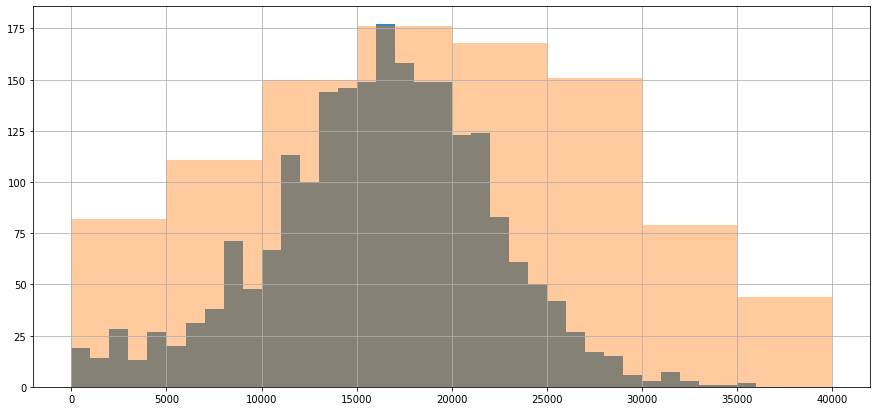

In [60]:
data_smart['month_mb_used'].hist(bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000, 21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000], figsize=(15,7), alpha=0.9)
data_ultra['month_mb_used'].hist(bins=[0,5000,10000,15000,20000,25000,30000,35000,40000], figsize=(15,7), alpha=0.4)

<AxesSubplot:>

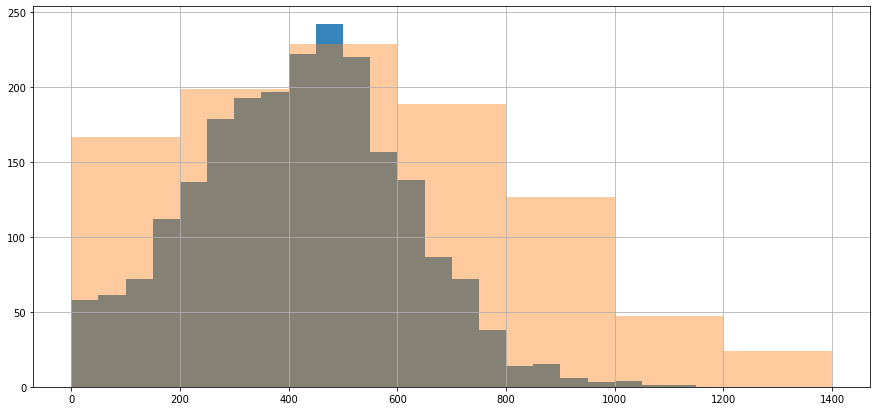

In [61]:
data_smart['month_call_duration'].hist(bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1400], figsize=(15,7), alpha=0.9)
data_ultra['month_call_duration'].hist(bins=[0, 200, 400, 600, 800, 1000, 1200, 1400], figsize=(15,7), alpha=0.4)

<AxesSubplot:>

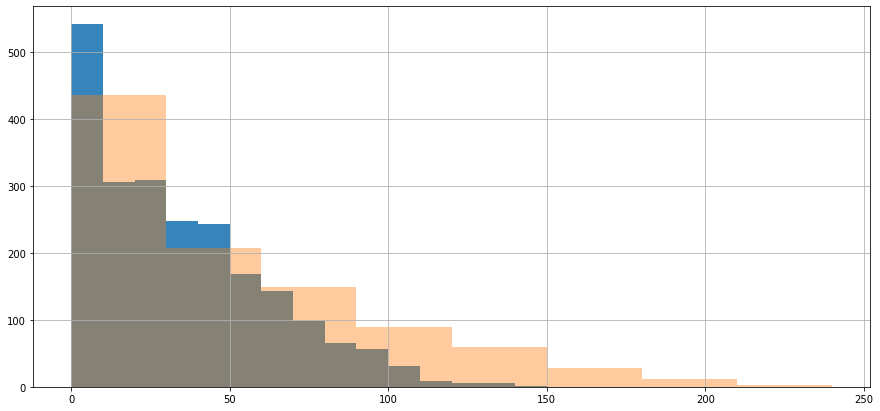

In [62]:
data_smart['month_message_count'].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], figsize=(15,7), alpha=0.9)
data_ultra['month_message_count'].hist(bins=[0, 30, 60, 90, 120, 150, 180, 210, 240], figsize=(15,7), alpha=0.4)

### Intermediate conclusions on histograms
1. Data on Internet traffic and the number of minutes have a normal distribution
2. The number of minutes for both tariffs is skewed to the left
3. The amount of traffic for the ultra tariff is slightly skewed to the right
4. The number of messages is described by the Poisson distribution

In [63]:
def print_params_data(data_users_info_with_tariff):
    params_list = ['month_mb_used', 'month_call_duration', 'month_message_count', 'proceeds']

    for param in params_list:
        print(param + ':')
        print('AVG = ', round(data_users_info_with_tariff[param].mean(), 2)) 
        print('MED = ', round(data_users_info_with_tariff[param].median(), 2)) 
        print('VAR = ', round(np.var(data_users_info_with_tariff[param], ddof=1), 2)) 
        print('STD = ', round(np.std(data_users_info_with_tariff[param], ddof=1), 2)) 
        print()

print('TARIFF: SMART')
print_params_data(data_smart)

TARIFF: SMART
month_mb_used:
AVG =  16221.91
MED =  16529.0
VAR =  34648523.3
STD =  5886.3

month_call_duration:
AVG =  417.75
MED =  421.5
VAR =  36281.39
STD =  190.48

month_message_count:
AVG =  33.37
MED =  28.0
VAR =  796.96
STD =  28.23

proceeds:
AVG =  1294.31
MED =  1037.0
VAR =  673877.62
STD =  820.9



In [64]:
print('TARIFF: ULTRA')
print_params_data(data_ultra)

TARIFF: ULTRA
month_mb_used:
AVG =  19467.14
MED =  19320.0
VAR =  102217264.28
STD =  10110.26

month_call_duration:
AVG =  526.09
MED =  518.0
VAR =  101052.49
STD =  317.89

month_message_count:
AVG =  49.31
MED =  38.0
VAR =  2285.42
STD =  47.81

proceeds:
AVG =  2070.94
MED =  1950.0
VAR =  143360.43
STD =  378.63



### Data Analysis Conclusions
The median is not significantly different from the mean, which means there are no outliers in the data and the mean can be used.
Users of the ultra tariff are more active in using the possibilities of their tariff, and smart users often do not fit into the restrictions of their tariff and overpay.

How many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month?

On average, then:

SMART

Traffic: 16.2 GB

Call duration: 419 minutes

Messages: 39

ULTRA

Traffic: 19.7 GB

Call duration: 545 minutes

Messages: 61

Let's calculate the approximate revenue from tariffs to support the final conclusions with figures:

In [65]:
print(data_smart['proceeds'].mean())
print(data_ultra['proceeds'].mean())

1294.3053811659192
2070.943204868154


## Hypothesis testing
Let's test the following hypotheses:

• the average revenue of users of Ultra and Smart tariffs differ;

• The average revenue of users from Moscow differs from the revenue of users from other regions.

### Hypotheses H0 and H1 on the average revenue of "Ultra" and "Smart" tariffs

Hypothesis H0: The average revenue from users of the "Smart" and "Ultra" tariffs is the same

Hypothesis H1: The revenue from users of the "Smart" tariff and the "Ultra" tariff differs

In [66]:
H0 = 'Не можем отвергнуть гипотизу - средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается'
from scipy import stats as st
alpha = 0.05 
results = st.ttest_ind(data_smart['proceeds'], data_ultra['proceeds'], equal_var = False)

if (results.pvalue < alpha):
    print(H1, results.pvalue)
else:
    print(H0, results.pvalue)

Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается 1.2414049931248708e-246


### Hypotheses H0 and H1 about average revenue in Moscow and other regions
Hypothesis H0: The average revenue from users in Moscow and the regions is the same

Hypothesis H1: The average revenue from users in Moscow and regions differs

In [67]:
data_moscow = data_users_info_with_tariff.query('city == "Москва"')
data_other = data_users_info_with_tariff.query('city != "Москва"')
H0 = 'Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и других регионов одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, cредняя выручка от пользователей Москвы и других регионов различается'

results = st.ttest_ind(data_moscow['proceeds'], data_other['proceeds'], equal_var = True)

if (results.pvalue < alpha):
    print(H1, results.pvalue)
else:
    print(H0, results.pvalue)

Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и других регионов одинакова 0.5277299573181309


### Conclusion on hypotheses

1. It is possible to reject the hypothesis about the equality of user revenues by tariffs, however, the degree of this difference and the sign need to be investigated further.
2. With a high degree of probability, the average revenue of users in Moscow and the regions turned out to be the same.

# Final conclusion of the study
We were provided with the data of the mobile operator "Megaline" on two tariff plans: "Smart" and "Ultra".
The purpose of the study was to identify for the commercial department which tariff brings more profit and which tariff is better.
We had data on 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018.

The data was preprocessed (Duplicates were not found. The redundant column Unnamed was removed. Time and date values ​​were converted to the correct format.)

Additional calculations were made for each user (number of calls made and spent minutes of conversation by month; number of messages sent by month; amount of Internet traffic spent by month; monthly revenue from each user.)

An analysis of some parameters was carried out (how many minutes of conversation, messages and how much Internet traffic is required by users of each tariff per month, the average, variance and standard deviation were calculated, histograms were built).

In terms of average revenue, the best tariff is "Ultra" (2073 rubles), the revenue for the "Smart" tariff is an average of 1305 rubles.
However, for the "Smart" tariff, users more often overpay for additional communication services, since they do not fit into the limits. And the Ultra tariff is overkill in terms of providing more services than most users use, so they also overpay.
Recommendations for the marketing department: the "Ultra" tariff brings more money.

# Additional findings from the study
Tariff revenue is not equal, you can further study this issue.

The average revenue by regions of Russia does not differ.

Users use the following volume of services on average per month:

SMART

Traffic: 16.2 GB

Call duration: 419 minutes

Messages: 39

ULTRA

Traffic: 19.7 GB

Call duration: 545 minutes

Messages: 61